In [21]:
import numpy as np 
import pandas as pd 
import os
import pandas as pd
import numpy as np
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [22]:
# Unzipping the training and testing folder 
train_zip = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip'
train_zip   = zipfile.ZipFile(train_zip, 'r')
train_zip.extractall('/kaggle/working')
train_zip.close()

test_zip ='/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip'
test_zip   = zipfile.ZipFile(test_zip, 'r')
test_zip.extractall('/kaggle/working')
test_zip.close()

### Data Exploration and Pre-processing

In [23]:
path = '/kaggle/working' 

train = os.path.join(path, 'train')
test = os.path.join(path, 'test')

print("Number of training images are: ", len(os.listdir(train)))
print("Number of testing images are: ", len(os.listdir(test)))

Number of training images are:  25000
Number of testing images are:  12500


In [24]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import zipfile

from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
import os
img_size = 120
train_image = []
files = os.listdir('/kaggle/working/train')
category = ''
for file in files:
    species = file.split('.')[0]
    if species == 'dog':
        category = 1
    else:
        category = 0
    image = cv2.imread('/kaggle/working/train/'+file, cv2.IMREAD_COLOR)
    image = cv2.resize(image,(img_size,img_size), interpolation=cv2.INTER_CUBIC)
    train_image.append([np.array(image), np.array(category)])

In [26]:
import random
random.shuffle(train_image)

img_size = 120
image = np.array([i[0] for i in train_image]).reshape(-1,img_size,img_size,3)
target = np.array([i[1] for i in train_image])

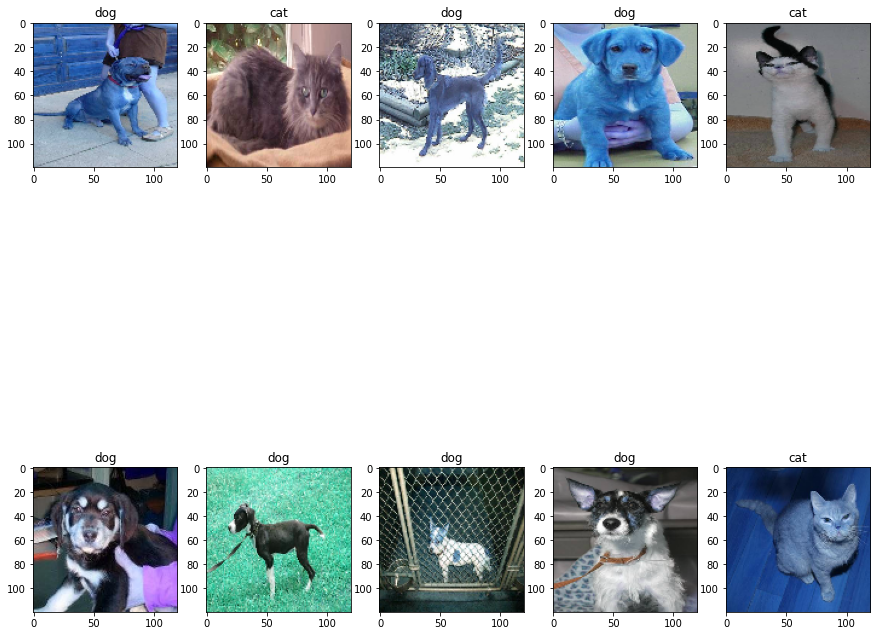

In [27]:
plt.figure(figsize=(15,15))
for k in range(10):
    plt.subplot(2, 5, k+1)
    img=random.randint(0,25000)
    plt.imshow(image[img])
    plt.title('cat' if target[img]==0 else 'dog')

### Splitting the training data into train and validation 

In [28]:

X_train, X_val, Y_train, Y_val = train_test_split(image, target, test_size = 0.4)

### For this prediction problem, 2 different models have been tried namely - CNN and ResidualNet50. 

### CNN Model

In [29]:
img_data_gen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range=10,
    zoom_range = 0.1,
    zca_whitening=False,
    width_shift_range=0.1,
    height_shift_range=0.1) 

In [30]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.005,
    patience=3,
    verbose=1,
    mode='auto')

In [31]:
lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=1,
    verbose=1,
    min_lr=0.000001)

In [32]:
optmzr = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999) 

#### CNN model defining 

In [33]:
model=Sequential()
model.add(Conv2D(64,(3,3),strides=1,padding='Same',activation='relu',input_shape=(X_train.shape[1],X_train.shape[2],3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

2022-04-05 21:15:42.222531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 21:15:42.303081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 21:15:42.303826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 21:15:42.305123: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [34]:
model.compile(optimizer = optmzr , metrics=["accuracy"],loss = "binary_crossentropy")

In [35]:
img_data_gen.fit(X_train)

In [36]:
callbacks = tf.keras.callbacks.Callback()

In [37]:
history = model.fit_generator(img_data_gen.flow(X_train, Y_train, batch_size=64),
                              validation_data=(X_val,Y_val), epochs=20, verbose=1,
                              callbacks=[callbacks, lr])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-04-05 21:15:47.460956: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-04-05 21:15:49.398445: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


235/235 [==============================] - 58s 215ms/step - loss: 0.8087 - accuracy: 0.6738 - val_loss: 0.5451 - val_accuracy: 0.7335
Epoch 2/20
235/235 [==============================] - 50s 215ms/step - loss: 0.4938 - accuracy: 0.7608 - val_loss: 0.4802 - val_accuracy: 0.7729
Epoch 3/20
235/235 [==============================] - 50s 212ms/step - loss: 0.4407 - accuracy: 0.7928 - val_loss: 0.6159 - val_accuracy: 0.7499

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
235/235 [==============================] - 51s 218ms/step - loss: 0.3740 - accuracy: 0.8288 - val_loss: 0.4407 - val_accuracy: 0.8233
Epoch 5/20
235/235 [==============================] - 50s 212ms/step - loss: 0.3332 - accuracy: 0.8533 - val_loss: 0.3833 - val_accuracy: 0.8360
Epoch 6/20
235/235 [==============================] - 49s 209ms/step - loss: 0.3013 - accuracy: 0.8683 - val_loss: 0.4047 - val_accuracy: 0.8352

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.

#### Plotting the various plot across epochs

In [38]:

def acc_val_acc_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    

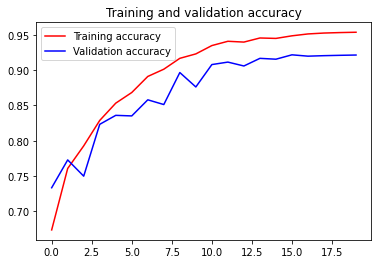

In [39]:
acc_val_acc_plot(history)

From the above plot, it is seen that around 17th epoch, the prediction accuracy is almost similar 

In [40]:
def loss_vs_val_loss_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

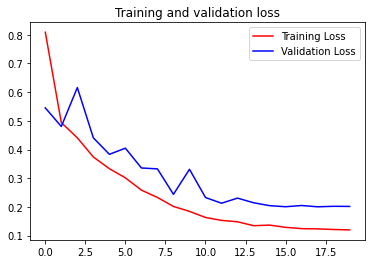

In [41]:
loss_vs_val_loss_plot(history)

From the loss graph it is seen that both training and validation loss decreases across epochs, so no indication of overfitting is observed. 

In [42]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy,lr
0,0.808661,0.673800,0.545058,0.7335,0.001000
1,0.493802,0.760800,0.480248,0.7729,0.001000
2,0.440688,0.792800,0.615893,0.7499,0.001000
3,0.373983,0.828800,0.440684,0.8233,0.000500
4,0.333158,0.853267,0.383307,0.8360,0.000500
5,0.301280,0.868333,0.404668,0.8352,0.000500
6,0.258516,0.891067,0.335715,0.8580,0.000250
7,0.232929,0.901333,0.332543,0.8513,0.000250
8,0.201646,0.916733,0.243886,0.8966,0.000125
9,0.184521,0.923000,0.331126,0.8762,0.000125


### Saving the CNN model for further use

In [43]:
from keras.models import load_model

model.save('cnn_cats_dogs_new.h5')

In [44]:
IMG_SIZE = 120
Images_test = []
for j in os.listdir('/kaggle/working/test/'):
    index = j.split('.')[0]
    img = cv2.imread('/kaggle/working/test/'+j, cv2.IMREAD_COLOR)
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_CUBIC)
    Images_test.append([np.array(img), np.array(index)])

In [45]:
X_test = np.array([i[0] for i in Images_test]).reshape(-1,IMG_SIZE, IMG_SIZE, 3)
Index = np.array([i[1] for i in Images_test])

In [46]:
test_prediction = model.predict(X_test, batch_size = 64)

In [47]:
submission_new=pd.DataFrame(test_prediction, columns=['label'], index=pd.Series(Index, name='id'))
submission_new.head()

,label
id,
2196,0.999863
8331,0.973028
11154,0.999996
7656,0.000110
4682,0.000599


### Saving the model output to csv format file

In [48]:
submission_new.to_csv('submission_new.csv')

### Residual Net

In [49]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import Model

In [50]:
resnet50=Sequential()
resnet50.add(ResNet50(input_shape=(120,120,3),
            include_top=False,pooling='max',
            weights='imagenet'))

In [51]:
resnet50.add(Dense(550,activation='relu'))
resnet50.add(Dropout(0.2))
resnet50.add(Dense(1,activation='sigmoid'))

In [52]:
resnet50.compile(optimizer=optmzr, loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
history_resnet50 =resnet50.fit_generator(img_data_gen.flow(X_train, Y_train, batch_size=32),
                                  validation_data=(X_val,Y_val), epochs=20, verbose=1,
                                  callbacks=[callbacks, lr, es])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
469/469 [==============================] - 77s 152ms/step - loss: 0.8923 - accuracy: 0.7501 - val_loss: 0.3972 - val_accuracy: 0.8705
Epoch 2/20
469/469 [==============================] - 69s 147ms/step - loss: 0.5174 - accuracy: 0.8403 - val_loss: 0.3244 - val_accuracy: 0.8964
Epoch 3/20
469/469 [==============================] - 69s 148ms/step - loss: 0.4570 - accuracy: 0.8635 - val_loss: 0.2877 - val_accuracy: 0.9082
Epoch 4/20
469/469 [==============================] - 69s 147ms/step - loss: 0.4111 - accuracy: 0.8735 - val_loss: 0.2654 - val_accuracy: 0.9155
Epoch 5/20
469/469 [==============================] - 72s 153ms/step - loss: 0.3778 - accuracy: 0.8849 - val_loss: 0.2464 - val_accuracy: 0.9218
Epoch 6/20
469/469 [==============================] - 69s 147ms/step - loss: 0.3448 - accuracy: 0.8955 - val_loss: 0.2314 - val_accuracy: 0.9273
Epoch 7/20
469/469 [==============================] - 68s 146ms/step - loss: 0.3262 - accuracy: 0.9002 - val_loss: 0.2215 - val_ac

In [60]:
from keras.models import load_model

resnet50.save('residual_net.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [3]:
test_prediction = resnet50.predict(X_test, batch_size = 64)

In [56]:
residual_new=pd.DataFrame(test_prediction, columns=['label'], index=pd.Series(Index, name='id'))
residual_new.head()

,label
id,
2196,1.000000e+00
8331,3.225210e-01
11154,1.000000e+00
7656,1.234617e-07
4682,1.586983e-07


In [57]:
residual_new.to_csv('residual_new.csv')

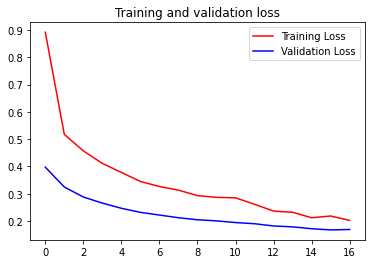

In [58]:
loss_vs_val_loss_plot(history_resnet50)

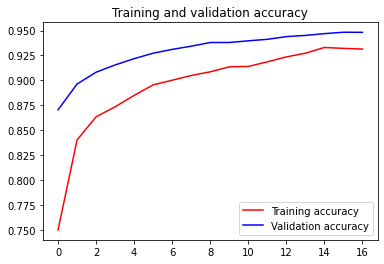

In [59]:
acc_val_acc_plot(history_resnet50)

Out of both the models, the Residual Net is giving better prediction results compared to Convolutional Neural Network. 